<a href="https://colab.research.google.com/github/SiddativeG/Marketing-Research-Models/blob/main/Customer_Lifetime_Value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime

# Load the dataset
file_path = '/content/Online_Sales_CLV - Online_Sales.csv.csv'  # Update with your file path
df = pd.read_csv(file_path)

# Convert Transaction_Date to datetime, handle mixed formats
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'], infer_datetime_format=True, errors='coerce')

# Check for rows with parsing errors
if df['Transaction_Date'].isnull().any():
    print("Warning: Some dates could not be parsed and were set to NaT. Please verify the data.")
    print(df[df['Transaction_Date'].isnull()])  # Display problematic rows

# Define the current date as a reference for recency calculation
current_date = df['Transaction_Date'].max()

# Calculate total revenue for each transaction
df['Revenue'] = df['Quantity'] * df['Avg_Price']

# --- RFM Analysis ---

# Group data by CustomerID to calculate RFM metrics
rfm = df.groupby('CustomerID').agg({
    'Transaction_Date': lambda x: (current_date - x.max()).days,  # Recency
    'Transaction_ID': 'nunique',  # Frequency
    'Revenue': 'sum'  # Monetary
}).reset_index()

# Rename columns for RFM
rfm.rename(columns={
    'Transaction_Date': 'Recency',
    'Transaction_ID': 'Frequency',
    'Revenue': 'Monetary'
}, inplace=True)

# Add RFM scores
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])  # 4: Most recent, 1: Least recent
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])  # 4: Most frequent
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])  # 4: Highest monetary value

# Combine RFM scores into a single RFM_Segment
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

# --- CLV Calculation ---

# Define the discount rate (r) and time horizon (N)
discount_rate = 0.1  # Example: 10% annual discount rate
time_horizon = 12  # Example: Predict CLV for 12 months

# Extract month from Transaction_Date for monthly aggregation
df['Month'] = df['Transaction_Date'].dt.to_period('M')

# Calculate the monthly revenue for each customer
monthly_revenue = df.groupby(['CustomerID', 'Month']).agg({'Revenue': 'sum'}).reset_index()

# Prepare a dataframe to calculate CLV
clv_data = pd.DataFrame({'CustomerID': monthly_revenue['CustomerID'].unique()})

# Function to calculate CLV for each customer
def calculate_clv(customer_id):
    customer_revenue = monthly_revenue[monthly_revenue['CustomerID'] == customer_id]
    total_clv = 0
    for t in range(1, time_horizon + 1):
        # Expected revenue in month t
        if t <= len(customer_revenue):
            expected_revenue = customer_revenue.iloc[t - 1]['Revenue']
        else:
            expected_revenue = 0  # No revenue data for future months
        # Discounted revenue
        total_clv += expected_revenue / ((1 + discount_rate) ** t)
    return total_clv

# Calculate CLV for each customer
clv_data['CLV'] = clv_data['CustomerID'].apply(calculate_clv)

# Merge CLV data with the RFM analysis
rfm_clv = rfm.merge(clv_data, on='CustomerID')

# Display the final dataframe with RFM metrics and CLV
import ace_tools as tools; tools.display_dataframe_to_user(name="RFM and CLV Analysis", dataframe=rfm_clv)


<ipython-input-6-4654a146bf29>:11: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'], infer_datetime_format=True, errors='coerce')


       CustomerID  Transaction_ID Transaction_Date     Product_SKU  \
1607        13468           17754              NaT  GGOEAAQB036114   
1608        13468           17754              NaT  GGOEAAQB036115   
1609        13468           17754              NaT  GGOEGAFB035817   
1610        13468           17755              NaT  GGOEGBFC018799   
1611        13468           17755              NaT  GGOEGDHB072199   
...           ...             ...              ...             ...   
52919       14410           48493              NaT  GGOENEBB078899   
52920       14410           48494              NaT  GGOEGAEB091117   
52921       14410           48495              NaT  GGOENEBQ084699   
52922       14600           48496              NaT  GGOENEBQ079199   
52923       14600           48497              NaT  GGOENEBQ079099   

                                   Product_Description Product_Category  \
1607                     Android Women's Fleece Hoodie          Apparel   
1608     

/usr/local/lib/python3.11/dist-packages/pandas/core/arrays/base.py:568: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(self, dtype=dtype)


ModuleNotFoundError: No module named 'ace_tools'

       CustomerID  Transaction_ID Transaction_Date     Product_SKU  \
1607        13468           17754              NaT  GGOEAAQB036114   
1608        13468           17754              NaT  GGOEAAQB036115   
1609        13468           17754              NaT  GGOEGAFB035817   
1610        13468           17755              NaT  GGOEGBFC018799   
1611        13468           17755              NaT  GGOEGDHB072199   
...           ...             ...              ...             ...   
52919       14410           48493              NaT  GGOENEBB078899   
52920       14410           48494              NaT  GGOEGAEB091117   
52921       14410           48495              NaT  GGOENEBQ084699   
52922       14600           48496              NaT  GGOENEBQ079199   
52923       14600           48497              NaT  GGOENEBQ079099   

                                   Product_Description Product_Category  \
1607                     Android Women's Fleece Hoodie          Apparel   
1608     

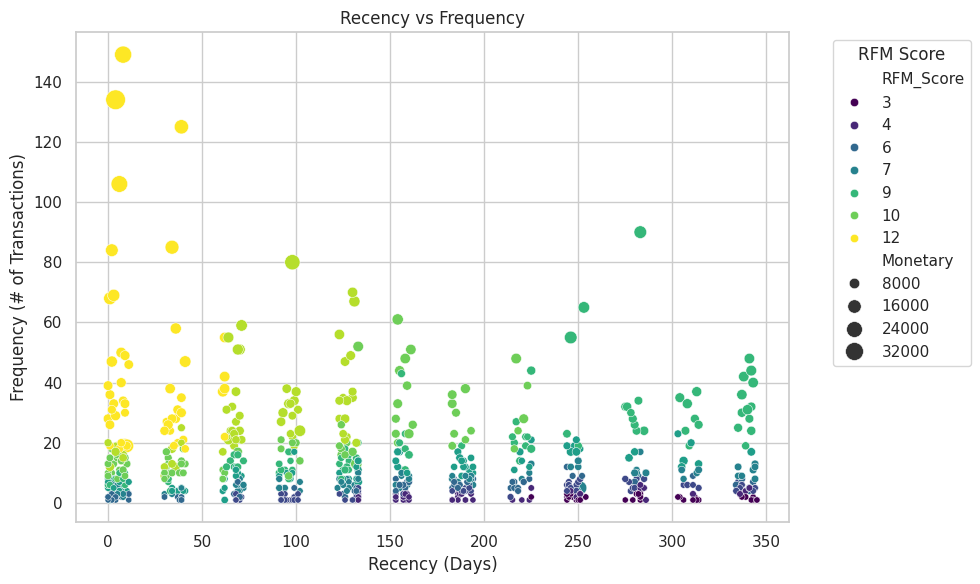

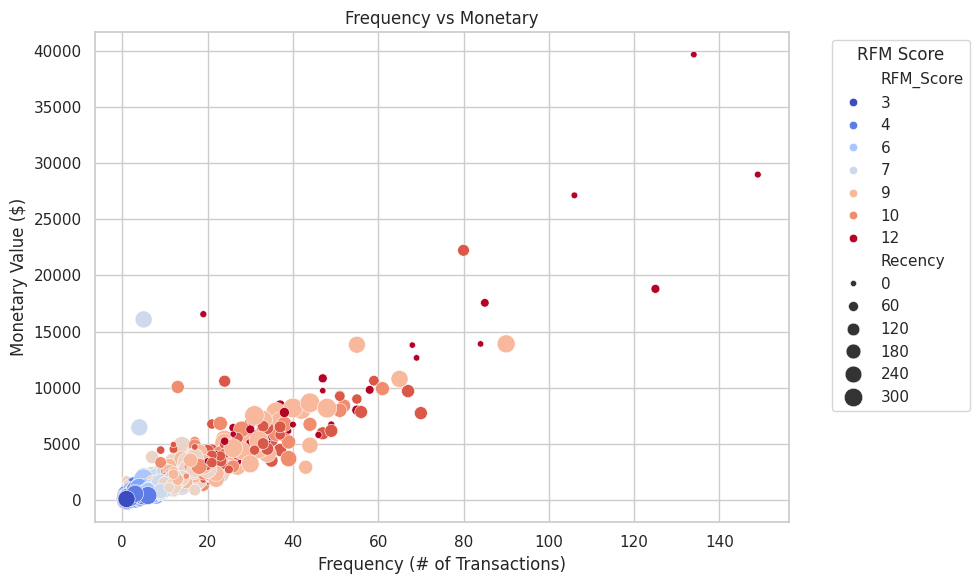

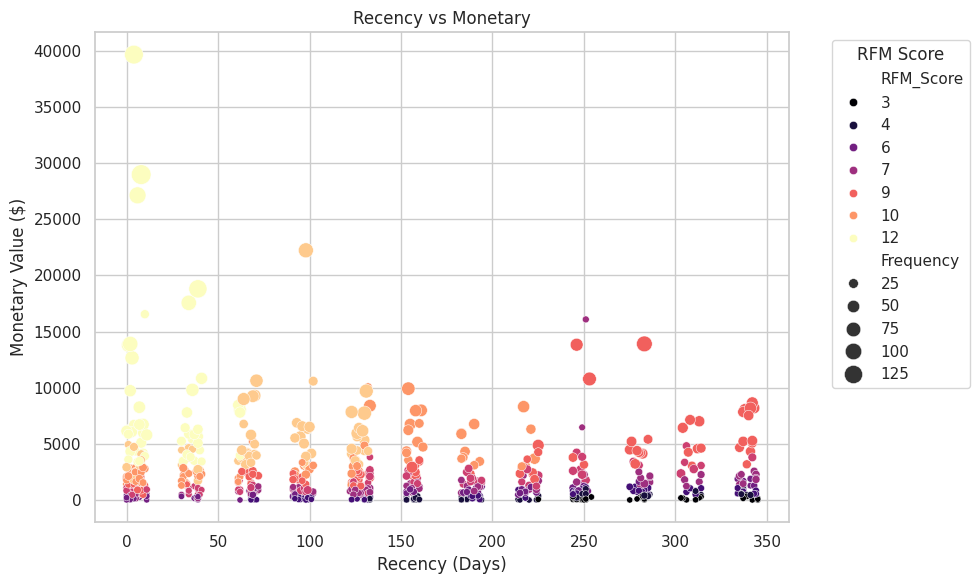

     CustomerID  Recency  Frequency  Monetary R_Score F_Score M_Score  \
0         12347       40         18   2618.85       4       3       3   
1         12373        5          5    471.58       4       2       2   
2         12377      160         16   3404.48       2       3       4   
3         12388       95         10    702.22       3       3       2   
4         12395      306          6    717.14       1       2       2   
..          ...      ...        ...       ...     ...     ...     ...   
770       18256      160          2     49.56       2       1       1   
771       18259      251          3    544.34       1       1       2   
772       18260       68         11   1113.95       3       3       2   
773       18269      251          1     86.87       1       1       1   
774       18283       63         31   4441.57       3       4       4   

    RFM_Segment  RFM_Score          CLV  
0           433         10  2380.772727  
1           422          8   428.709091

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '/content/Online_Sales_CLV - Online_Sales.csv.csv'  # Update with your file path
df = pd.read_csv(file_path)

# Convert Transaction_Date to datetime
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'], errors='coerce')

# Check for rows with parsing errors
if df['Transaction_Date'].isnull().any():
    print("Warning: Some dates could not be parsed and were set to NaT. Please verify the data.")
    print(df[df['Transaction_Date'].isnull()])  # Display problematic rows

# Drop rows with invalid dates (optional)
df = df.dropna(subset=['Transaction_Date'])

# Define the current date as a reference for recency calculation
current_date = df['Transaction_Date'].max()

# Calculate total revenue for each transaction
df['Revenue'] = df['Quantity'] * df['Avg_Price']

# --- RFM Analysis ---

# Group data by CustomerID to calculate RFM metrics
rfm = df.groupby('CustomerID').agg({
    'Transaction_Date': lambda x: (current_date - x.max()).days,  # Recency
    'Transaction_ID': 'nunique',  # Frequency
    'Revenue': 'sum'  # Monetary
}).reset_index()

# Rename columns for RFM
rfm.rename(columns={
    'Transaction_Date': 'Recency',
    'Transaction_ID': 'Frequency',
    'Revenue': 'Monetary'
}, inplace=True)

# Add RFM scores
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])  # 4: Most recent, 1: Least recent
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])  # 4: Most frequent
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])  # 4: Highest monetary value

# Combine RFM scores into a single RFM_Segment
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

# --- CLV Calculation ---

# Define the discount rate (r) and time horizon (N)
discount_rate = 0.1  # Example: 10% annual discount rate
time_horizon = 12  # Example: Predict CLV for 12 months

# Extract month from Transaction_Date for monthly aggregation
df['Month'] = df['Transaction_Date'].dt.to_period('M')

# Calculate the monthly revenue for each customer
monthly_revenue = df.groupby(['CustomerID', 'Month']).agg({'Revenue': 'sum'}).reset_index()

# Prepare a dataframe to calculate CLV
clv_data = pd.DataFrame({'CustomerID': monthly_revenue['CustomerID'].unique()})

# Function to calculate CLV for each customer
def calculate_clv(customer_id):
    customer_revenue = monthly_revenue[monthly_revenue['CustomerID'] == customer_id]
    total_clv = 0
    for t in range(1, time_horizon + 1):
        # Expected revenue in month t
        if t <= len(customer_revenue):
            expected_revenue = customer_revenue.iloc[t - 1]['Revenue']
        else:
            expected_revenue = 0  # No revenue data for future months
        # Discounted revenue
        total_clv += expected_revenue / ((1 + discount_rate) ** t)
    return total_clv

# Calculate CLV for each customer
clv_data['CLV'] = clv_data['CustomerID'].apply(calculate_clv)

# Merge CLV data with the RFM analysis
rfm_clv = rfm.merge(clv_data, on='CustomerID')

# --- Visualization ---

# Set plot style
sns.set(style="whitegrid")

# Plot Recency vs Frequency
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Frequency', data=rfm_clv, hue='RFM_Score', palette='viridis', size='Monetary', sizes=(20, 200))
plt.title('Recency vs Frequency')
plt.xlabel('Recency (Days)')
plt.ylabel('Frequency (# of Transactions)')
plt.legend(title='RFM Score', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot Frequency vs Monetary
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Frequency', y='Monetary', data=rfm_clv, hue='RFM_Score', palette='coolwarm', size='Recency', sizes=(20, 200))
plt.title('Frequency vs Monetary')
plt.xlabel('Frequency (# of Transactions)')
plt.ylabel('Monetary Value ($)')
plt.legend(title='RFM Score', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot Recency vs Monetary
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Monetary', data=rfm_clv, hue='RFM_Score', palette='magma', size='Frequency', sizes=(20, 200))
plt.title('Recency vs Monetary')
plt.xlabel('Recency (Days)')
plt.ylabel('Monetary Value ($)')
plt.legend(title='RFM Score', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Export to CSV or display
rfm_clv.to_csv('rfm_clv_analysis.csv', index=False)  # Save to CSV
print(rfm_clv)  # Print the result